# Chapter6 : Deep learning for text and sequences

## 6.3 Advanced use of recurrent nerual networks

In this section, we'll review three advanced techniques for improving the performance and generalization power of recurrent neural networks.

We'll demonstrate all three concepts on a temperature-forecasting problem, where you have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which you use to predict what the temerature will be 24 hours after the last data point.

We will cover the following techniques:
  + *Recurrent dropout*--This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.
  + *Stacking recurrent layers*--This increases the representational power of the network (at the cost of higher computational loads).
  + *Bidirectional recurrent layers*--These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### 6.3.1 A temperature-forecasting problem

In this dataset, 14 different quantities were recorded every 10 minutes, over several years. This dataset is perfect for learning to work with numerical timeseries. You'll use it the build a model that takes as input some data from the recent past and predicts the air temperature 24 hours in the future.

#### Inspecting the data of the Jena weather dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import os
data_dir = '/content/gdrive/My Drive/github/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print('Length of data:', len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Length of data: 420551


#### Parsing the data

In [0]:
import numpy as np
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

#### Plotting the temperature timseries

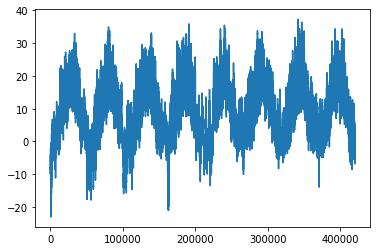

In [6]:
import matplotlib.pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

#### Plotting the first 10 days of the temperature timeseries

Here is a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 1440 data points per day.

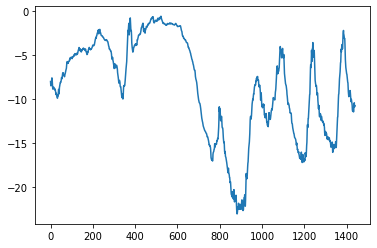

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 6.3.2 Preparing the data

The exact formulation of the problem will be as follows:
  + **lookback = 720**--Observations will go back 5 days.
  + **steps = 6**--Observations will be sampled at one data point per hour.
  + **delay = 144**--Targets will be 24 hours in the future.

To get started, you need to do two things:
  + Preprocess the data to a format a neural network can ingest. Each timeseries in the data is on a different scale. You'll normalize each timeseries independently so that they all take small values on a similar scale.
  + Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future

* You're going to use the first 200,000 timestamps as training data, so compute the mean and standard deviation only on this fraction of the data.

#### Normalizing the data

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

The data generator takes the following arguments:
  + `data`--The original array of floating-point data, which you normalized in the previous code.
  + `lookback`--How many timestamps back the input data should go.
  + `delay`--How many timestamps in the future the target should be.
  + `min_index` and `max_index`--Indices in the *data* array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
  + `shuffle`--Whether to shuffle the samples of draw them in chronological order.
  + `step`--The period, in timestamps, at which you sample data. In this example, you'll set it to 6 in order to draw one data point every hour.

#### Generator yielding timeseries samples and their targets

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                 min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### Preparing  the training, validation, and test generators

In [0]:
lookback = 720
step = 6
delay = 144
batch_size = 128

In [0]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

In [0]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

In [0]:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [14]:
# how many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size
val_steps

775

In [15]:
# how many steps to draw from test_gen in order to see the entire test set
test_steps = (len(float_data) - 300001 - lookback) // batch_size
test_steps

936

### 6.3.3 A common-sense, non-machine-learning baseline

A common-sense approach will serve as a sanity check, and it will establish a baseline that you'll have to beat in order to demonstrate the usefulness of more-advanced machine-learning models. Such common-sense baselines can be useful when you're approaching a new problem for which there is no known solution. However, you should keep in mind that such elementary baselines can prove surprisingly hard to beat.

In this case, the temperature can safely be assumed to be continuous as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now.

#### Computing the common-sense baseline MAE

In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [17]:
evaluate_naive_method()

0.2905218778760465


> This yields an MAE of 0.29. It translates to an average absolute error of 0.29×**temperature_std** degrees Celsius: 2.57℃.

#### Converting the MAE back to a Celsius error

In [18]:
celsius_mae = 0.29*std[1]
celsius_mae

2.5672247338393395

### 6.3.4 A basic machine-learning approach

In the same way that it's useful to establish a common-sense baseline before trying machine-learning approaches, it's useful to try simple, cheap machine-learning models before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

Because you evaluate on the exact same data and with the exact same metric you did with the common-sense approach, the results will be directly comparable.

#### Training and evaluating a densely connected model

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [20]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
              loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=2)

Epoch 1/20
 - 9s - loss: 0.7527 - val_loss: 0.2358
Epoch 2/20
 - 7s - loss: 0.3329 - val_loss: 0.1692
Epoch 3/20
 - 7s - loss: 0.2854 - val_loss: 0.3409
Epoch 4/20
 - 7s - loss: 0.2695 - val_loss: 0.3827
Epoch 5/20
 - 7s - loss: 0.2599 - val_loss: 0.3713
Epoch 6/20
 - 7s - loss: 0.2517 - val_loss: 0.2825
Epoch 7/20
 - 7s - loss: 0.2470 - val_loss: 0.2445
Epoch 8/20
 - 7s - loss: 0.2442 - val_loss: 0.3055
Epoch 9/20
 - 8s - loss: 0.2409 - val_loss: 0.2707
Epoch 10/20
 - 7s - loss: 0.2384 - val_loss: 0.1974
Epoch 11/20
 - 7s - loss: 0.2359 - val_loss: 0.3758
Epoch 12/20
 - 7s - loss: 0.2332 - val_loss: 0.4404
Epoch 13/20
 - 7s - loss: 0.2324 - val_loss: 0.3368
Epoch 14/20
 - 7s - loss: 0.2286 - val_loss: 0.3813
Epoch 15/20
 - 7s - loss: 0.2264 - val_loss: 0.2928
Epoch 16/20
 - 7s - loss: 0.2266 - val_loss: 0.2565
Epoch 17/20
 - 7s - loss: 0.2236 - val_loss: 0.2826
Epoch 18/20
 - 7s - loss: 0.2204 - val_loss: 0.3423
Epoch 19/20
 - 7s - loss: 0.2200 - val_loss: 0.3463
Epoch 20/20
 - 7s - l

#### Plotting results

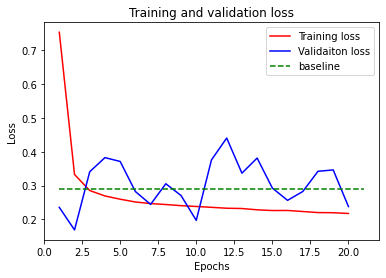

In [21]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaiton loss')
plt.plot([1, 21], [0.29, 0.29], 'g', linestyle='dashed', label='baseline')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

> Some of the validation losses are close to the no-learning baseline, but not reliably. Your common sense contains a lot of valuable information that a machine-learning model doesn't have access to.

You may wonder, if a simple, well-performing model exists to go from the data to the targets, why doesn't the model you're training find it and improve on it?

  + This is because this simple solution isn't what your training setup is looking for. **When you're looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it's technically part of the hypothesis space.** This is a pretty significant limitation of machine learning in general: *parameter learning can sometimes fail to find a simple solution to a simple problem*.

### 6.3.5 A first recurrent baseline

The previous approach first flattened timeseries, which removed the notion of time from the input data. Instead, let's look at the data as what it is: a sequence, where causality and order matter.

Also, instead of using the LSTM layer introduced in the previous section, you'll use the GRU layer. Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they're somewhat streamlined and thus cheaper to run.

#### Training and evaluating a GRU-based model

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [28]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
              loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=500,
                              verbose=2)

Epoch 1/20
 - 130s - loss: 0.3058 - val_loss: 0.2675
Epoch 2/20
 - 131s - loss: 0.2832 - val_loss: 0.1695
Epoch 3/20
 - 130s - loss: 0.2784 - val_loss: 0.2150
Epoch 4/20
 - 130s - loss: 0.2728 - val_loss: 0.1614
Epoch 5/20
 - 130s - loss: 0.2687 - val_loss: 0.3367
Epoch 6/20
 - 127s - loss: 0.2651 - val_loss: 0.4326
Epoch 7/20
 - 129s - loss: 0.2594 - val_loss: 0.2875
Epoch 8/20
 - 129s - loss: 0.2565 - val_loss: 0.1625
Epoch 9/20
 - 128s - loss: 0.2526 - val_loss: 0.0800
Epoch 10/20
 - 127s - loss: 0.2474 - val_loss: 0.3770
Epoch 11/20
 - 130s - loss: 0.2452 - val_loss: 0.2834
Epoch 12/20
 - 127s - loss: 0.2409 - val_loss: 0.1198
Epoch 13/20
 - 128s - loss: 0.2376 - val_loss: 0.0674
Epoch 14/20
 - 128s - loss: 0.2319 - val_loss: 0.1287
Epoch 15/20
 - 128s - loss: 0.2304 - val_loss: 0.1747
Epoch 16/20
 - 127s - loss: 0.2262 - val_loss: 0.4217
Epoch 17/20
 - 128s - loss: 0.2229 - val_loss: 0.1511
Epoch 18/20
 - 128s - loss: 0.2193 - val_loss: 0.3200
Epoch 19/20
 - 130s - loss: 0.2155 - 

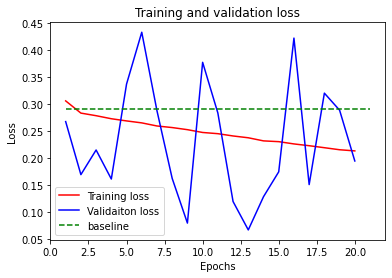

In [29]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaiton loss')
plt.plot([1, 21], [0.29, 0.29], 'g', linestyle='dashed', label='baseline')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

> Much better! You can significantly beat the common-sense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.